In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import kagglehub
from PIL import Image
import cv2
from tensorflow import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Input
import os
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import LabelEncoder

In [2]:
# import os
# from kaggle.api.kaggle_api_extended import KaggleApi

# api = KaggleApi()
# api.authenticate()

# # Specify the dataset and path
# dataset_name = "masoudnickparvar/brain-tumor-mri-dataset"
# download_path = "/Users/ryakennakamoto/School/remake_machine/"

# # Download the dataset
# api.dataset_download_files(dataset_name, path=download_path, unzip=True)

In [3]:
def collect_data(train_prefix):
    """
        Input:
            train_prefix (str): will either be Training or Testing

        Output:
            df (DataFrame): raw labeled data
    """
    data = []
    
    for folder in os.listdir(train_prefix):
        folder_path = os.path.join(train_prefix, folder)
        # going into each 
        for img in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img)
            label = folder # either notumor, pituitary, meningioma, or glicoma 
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to rbg
            img = cv2.resize(img, (256, 256)) 
            img_data = np.array(img)
            data.append({"label": label, "pixels": img_data})
    df = pd.DataFrame(data)
    return df

In [4]:
df_training = collect_data('./Training')
df_testing = collect_data('./Testing')

print(df_testing.shape)
print(df_training.shape)

(1311, 2)
(5712, 2)


In [5]:
print(df_training['label'].value_counts())
categories = df_training['label'].unique()

label
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64


In [6]:
print(df_training.head())
print(df_training.tail())

       label                                             pixels
0  pituitary  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
1  pituitary  [[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...
2  pituitary  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
3  pituitary  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
4  pituitary  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
           label                                             pixels
5707  meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
5708  meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
5709  meningioma  [[[52, 52, 52], [46, 46, 46], [49, 49, 49], [4...
5710  meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
5711  meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...


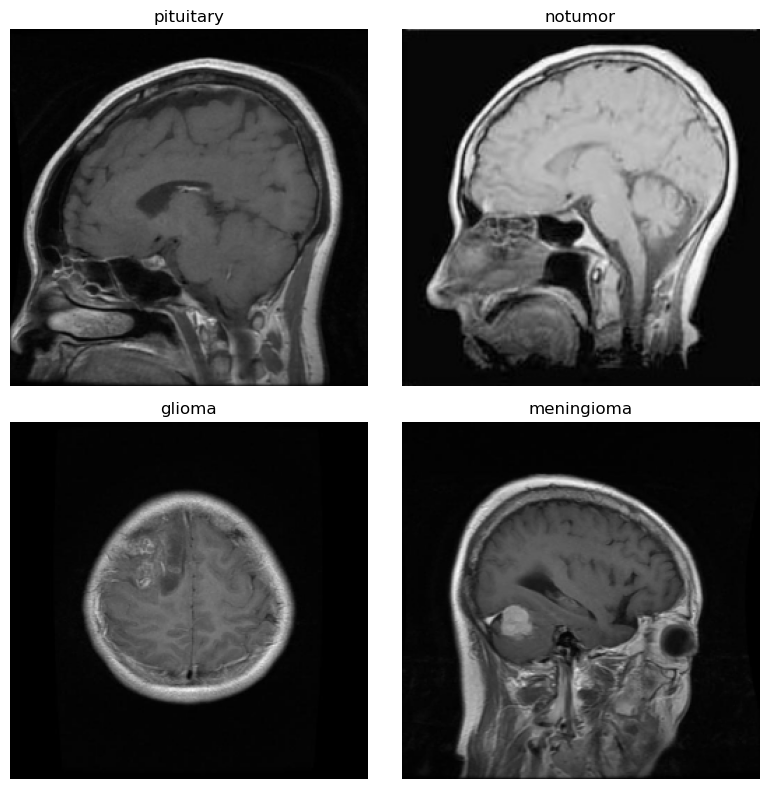

In [7]:
# 2x2 figure
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for idx, category in enumerate(categories):
    # filtering
    subset = df_training[df_training['label'] == category]
    
    # random img
    random_idx = random.randint(0, len(subset) - 1)
    image_data = subset.iloc[random_idx]['pixels']
    
    row, col = divmod(idx, 2)
    axes[row, col].imshow(image_data)
    axes[row, col].set_title(category)
    axes[row, col].axis('off') 

plt.tight_layout()
plt.show()

***After exploring data***

In [8]:
def preprocess(raw_data):
    """
    takes in the dataframes from visualizing data, returns corresponding
    numpy arrays to be passed directly into training, X and y.
    """
    raw_data['pixels'] = raw_data['pixels'] / 255 # normalizing between [0,1]
    encoder = LabelEncoder()
    raw_data['y_encoded'] = encoder.fit_transform(raw_data['label'])
    # for future reference this is label mapping
    label_mapping = dict(zip(encoder.classes_, range(len(encoder.classes_))))
    print("Label Mapping:", label_mapping)
    print("Encoded Labels:", raw_data['y_encoded'].head())
    raw_data_shuffled = raw_data.sample(frac=1).reset_index(drop=True)
    # now assign numbers to each of the labels
    X = np.stack(raw_data_shuffled['pixels'].to_numpy())
    y = raw_data_shuffled['y_encoded'].to_numpy()
    # one hot encode y
    y = tf.keras.utils.to_categorical(y, num_classes=4)

    return X, y

In [9]:
X_train, y_train = preprocess(df_training)
X_test, y_test = preprocess(df_testing)

Label Mapping: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Encoded Labels: 0    3
1    3
2    3
3    3
4    3
Name: y_encoded, dtype: int64
Label Mapping: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Encoded Labels: 0    3
1    3
2    3
3    3
4    3
Name: y_encoded, dtype: int64


In [10]:
# saving data for later use
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

In [11]:
# loading it up
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

In [12]:
# dnn model, comparison to cnn
def dnn_model(X_train, y_train, X_test, y_test):
    # flatten it to 1D for each training set
    X_train_flat = X_train.reshape(len(X_train), -1)
    X_test_flat = X_test.reshape(len(X_test), -1)
    
    # creating structure
    model = keras.Sequential([
        Input(shape=(256*256*3,)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(4, activation='softmax')
    ])
    
    # setting criteria for learning
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # doing the actual training
    model.fit(X_train_flat, y_train, epochs=5)
    
    # determining accuracy
    model.evaluate(X_train_flat, y_train)

    model.summary()

In [13]:
dnn_model(X_train, y_train, X_test, y_test)

Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.5158 - loss: 3.9466
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.7057 - loss: 0.9822
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.8002 - loss: 0.5691
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.8421 - loss: 0.4217
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.8448 - loss: 0.3990
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8868 - loss: 0.2963


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │    25,165,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,529,262 (288.12 MB)

 Trainable params: 25,176,420 (96.04 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 50,352,842 (192.08 MB)

In [14]:
def cnn_model(X_train, y_train, X_test, y_test):

    
    model = tf.keras.models.Sequential([
        # identifying basic features like edges
        Input(shape=(256,256,3)),
        Conv2D(64, (3,3), activation='relu'),
        # intensifying those features
        MaxPooling2D(2,2),
        # identifying more features 
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        # sets up for the dense layer
        keras.layers.Flatten(),
        # to prevent overfitting
        Dropout(0.5),
        # gathers all the data together
        Dense(512, activation='relu'),
        Dense(4, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=5)

    model.evaluate(X_test, y_test)

    model.summary()

    model.save('cnn_model.keras')

In [15]:
cnn_model(X_train, y_train, X_test, y_test)

Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 115s 638ms/step - accuracy: 0.6201 - loss: 1.8909
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 114s 638ms/step - accuracy: 0.9175 - loss: 0.2251
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 116s 647ms/step - accuracy: 0.9650 - loss: 0.1039
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 115s 641ms/step - accuracy: 0.9732 - loss: 0.0779
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 115s 644ms/step - accuracy: 0.9855 - loss: 0.0414
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.9485 - loss: 0.1764


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │   125,960,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 378,004,430 (1.41 GB)

 Trainable params: 126,001,476 (480.66 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 252,002,954 (961.31 MB)